In [58]:
###############################################
#
#      BIGRAM LLM build with a Neural Network
#
###############################################

import torch
import matplotlib.pyplot as plt

with open('names.txt', 'r') as file:
    names = file.readlines()
names = [name.strip().lower() for name in names] # only lowercase letters to get 26 chars

SPECIAL_CH = '.'

chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i, s in enumerate(chars)} # {'a':1, 'b':2, 'c':3, ..., 'z':26}
# print(stoi)
stoi[SPECIAL_CH] = 0
itos = {i:s for s, i in stoi.items()}

# include counting the special char with the chars in the dataset - 27 total
NUM_CHARS = len(chars + [SPECIAL_CH])

# create a training set of bigrams ( x (1st char),y (2nd char) )

# inputs (xs) and targets (ys)
xs, ys = [], []

for name in names[:1]:
    chs = [SPECIAL_CH] + list(name) + [SPECIAL_CH]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1] # get the number for the char from the stoi dict
        ix2 = stoi[ch2]
        xs.append(ix1) # first chars
        ys.append(ix2) # second chars

# create tensors from the lists of bigrams assembled
xs = torch.tensor(xs) # note: use lowercase tensor() not Tensor() - that one forces the dtype to be float and lowercase tensor() infers the datatype
ys = torch.tensor(ys)

print(f'Int representation of first chars: {xs}') # inputs
print(f'Int representation of second chars: {ys}') # labels (targets)
# When xs[i] (first chars in bigram) is entered we want ys[i] (second chars in bigram) to have a high probability: example: When 0 is entered we want 5 to have a high probability

Int representation of first chars: tensor([ 0,  5, 13, 13,  1])
Int representation of second chars: tensor([ 5, 13, 13,  1,  0])


torch.Size([5, 27])
torch.float32
Onehot encoded inputs: tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])


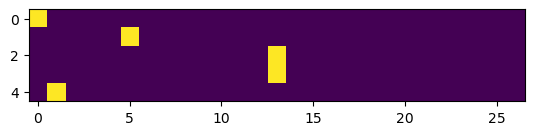

In [59]:
###################
# ONE HOT ENCODING
###################

# Not ideal to pass in integers to neural networks (due to calculations on floats), so we use One Hot Encoding
# We want float values for a nueral net so they can take on various/continuous values
# create a vector made up of dimensions matching the integer and turn the i-th element (the integer index) into a 1
# This vector can feed into a neural net

import torch.nn.functional as F

# one hot encoding. Pass in the integers you want to encode. num_classes is how many elements in the vector
xenc = F.one_hot(xs, num_classes=NUM_CHARS) # we only need 27 elements in the vector representing 26 letters of the dataset and 1 special token '.'
print(xenc.shape) # [5,27] one row for each letter, 27 elements in each vector
# print(xenc.dtype) # int64 - caution!

# cast the returned type from one_hot() to a float (it returns int64 integers, but we need floats to feed into neural nets)
xenc = xenc.float()
print(xenc.dtype)
print(f'Onehot encoded inputs: {xenc}')

plt.imshow(xenc) # visualize the one hot encoded chars
plt.show()

# each row is an example that can be fed into a neural net. The appropriate bit is turned on as a 1 (yellow block) and everything else is 0 (purple blocks)

In [60]:
########## Feed into Neurons ##############

### How matrix multiplication works ###

# Define the weights - use random nums
W = torch.randn((NUM_CHARS,1)) # normally distributed numbers - most will be around 0, and the tails are thin around magnitude of 3,-3
print(f'Weights: {W}\n') # Column vector of 27 (NUM_CHARS) numbers - these will be multiplied by the inputs

# multiply the encoded inputs by the weights using matrix multiplication
print(f'xenc@W: {xenc @ W}\n')

# matrix multiplication of [5, 27] @ [27, 1] takes the 27 cols of input bits (per row) and multiplies by the 27 rows of W (one weight copied 27 times to fill out each row) and takes the sum (dot product)
  # the col values in each of the 5 rows represent the 27 characters and which character is "turned on" - the bit as seen in the above xenc output
# this shows us the five activations on this neuron depending on each of the 5 inputs

turned_on_indices = torch.where(xenc>0) # first tensor = which row, second tensor = which col
print(f'{turned_on_indices=}\n')

# Matrix multiplication goes for all the values in the xenc row, they are multplied by each col value in W in this case (since there is only 1 column each row val goes down the vals element-wise))
  # Most of the values per row in xenc are 0 until we find the bit representing the char that is turned on. This will be a 1. and will be multiplied by the corresponding col value in W - 
  # the sum of the dotproduct will match 1xWcol_val since we only have one col in W
# xenc[0][0] x W[0][0]
# xenc[0][1] x W[1][0]
# xenc[0][2] x W[2][0]
# ...

r = turned_on_indices[0]
c = turned_on_indices[1]
print(f'First char bit turned on (={xenc[r[0]][c[0]]}): row={r[0]},col={c[0]} = corresponding weight val {W[c[0]][0]:.4f} = row {c[0]} in W')
print(f'Second char bit turned on (={xenc[r[1]][c[1]]}): row={r[1]},col={c[1]} = corresponding weight val {W[c[1]][0]:.4f} = row {c[1]} in W')


Weights: tensor([[-0.8483],
        [-0.9814],
        [ 0.6555],
        [ 1.8274],
        [-1.5643],
        [ 1.0468],
        [ 0.6342],
        [-0.9268],
        [-0.5834],
        [ 2.0462],
        [ 0.2838],
        [-0.3499],
        [ 0.0488],
        [ 0.1603],
        [-0.0943],
        [-0.9668],
        [ 0.7556],
        [-1.5551],
        [ 1.1384],
        [-0.2670],
        [-0.6171],
        [ 0.7536],
        [-0.0066],
        [ 1.1313],
        [-0.4115],
        [-0.1872],
        [-0.0638]])

xenc@W: tensor([[-0.8483],
        [ 1.0468],
        [ 0.1603],
        [ 0.1603],
        [-0.9814]])

turned_on_indices=(tensor([0, 1, 2, 3, 4]), tensor([ 0,  5, 13, 13,  1]))

First char bit turned on (=1.0): row=0,col=0 = corresponding weight val -0.8483 = row 0 in W
Second char bit turned on (=1.0): row=1,col=5 = corresponding weight val 1.0468 = row 5 in W


In [68]:
# The above is for one neuron, but we want more neurons which represent one layer in a neural net

# weights
W = torch.randn(NUM_CHARS, NUM_CHARS) # 27x27 - first arg is the column of weight values to use, the second argument represents the number of neurons
# [ [...weights], [...for which neuron] ] - rows = weights, cols = neurons

dot_prods = xenc @ W # now we have a 5x27 matrix (the five onehot encoded inputs to the NN multiplied by  )

# this shows the dot product of the third input and the 13th column of the W (weights) matrix
print(f'Firing rate of 14th neuron looking at 4th input (row): {dot_prods[3,13]}\n')
# the firing rate is the dot product of that intput (the row values of xenc) multiplied by the weights (column values) for that neuron:
print(f'xenc 4th row: {xenc[3]}\n')
print(f'W 14th column: {W[:,13]}')
# print(f'Dot product of 4th input against 13th col of W: {xenc[3] @ W[:,13]}')
print(f'Dot product of 4th input against 13th col of W: {(xenc[3] * W[:,13]).sum()}') # should match firing rate printed above

### This matrix multiplication allows us to look at multiple input examples input into a layer of neurons in a neural net (i.e. 27 inputs into a layer of 27 neurons here)
## NOTE: This layer is a linear layer (there is no bias or squashing function like tanh applied, just weights x inputs).
        # This NN is also going to be just one layer (as simple as possible NN)

print(f'\nInputs x Weights (27 neurons): {dot_prods}')

Firing rate of 14th neuron looking at 4th input (row): -1.15359365940094

xenc 4th row: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

W 14th column: tensor([-0.4910,  1.8493,  0.5872, -0.0911,  1.1150,  0.2830,  0.9598, -2.1307,
         1.1073,  0.9683,  0.0060,  2.3248, -0.9708, -1.1536, -0.4835, -0.3690,
        -1.3254,  2.1836,  0.2524,  1.0682, -1.1253, -0.3265,  1.8109, -0.3836,
        -0.3129,  0.6867, -0.5146])
Dot product of 4th input against 13th col of W: -1.15359365940094

Inputs x Weights (27 neurons): tensor([[-0.0986,  0.5525, -1.8008,  1.0911, -0.5890, -0.3384,  0.6064,  1.2956,
         -0.6839,  1.5796, -0.0926,  0.1417, -0.3951, -0.4910, -0.1217, -1.4546,
         -0.4901,  0.9054,  0.2273,  0.0445,  0.2756,  0.3142,  0.0137,  0.0660,
         -1.7717,  1.0799, -0.9139],
        [ 1.3838, -1.9828, -1.2792,  1.1236, -1.0411, -1.3925,  2.4700,  0.1871,
          0.1091,  0.1754,  0.8831, 

In [ ]:
# Define what you want the outputs of the NN layer to be (27 outputs, one per neuron in the layer)

# We need a probability distribution for what the next character could be given a character input